# (i) Machine Learning Approach to the Implementation of Respiratory rate estimation

In this appraoch I will implement 9 supervised machine learning algorithms to proceed with respiratory rate estimation. This whole process will be implemented in stages. These stages are:

1. Data Loading
2. Pre-processing
3. data manipulation
4. model fitting
5. model training
6. model testing
7. feature and importance selection
8. output visualization

### Imports of libraries used for preprocessing data

In [14]:
import requests
from os import listdir, mkdir
from os.path import isdir, isfile, join
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from tqdm import tqdm
import seaborn as sns

### Dataset extraction links

In [2]:
baseURL = 'https://physionet.org/physiobank/database/bidmc/bidmc_csv/'

In [ ]:
endingFiles = ['_Breaths.csv','_Numerics.csv','_Signals.csv','_Fix.txt']

### Files segmentation of all 53 patients

In [3]:
# The Dictionary below holds the files mentioned in ending files consisting of all the patients
filesHolder = {}

# The array below represents number of strings collected in the array
val = []
S
for e in range(1,54):
    if e<10:
        val.append('0'+str(e))
    else:
        val.append(str(e))

In [ ]:
# The below loop collate all the files in the filesHolder array
for e in val:
    filesHolder[e] = ['bidmc_'+e+ending for ending in endingFiles]

### Csv and text files extraction in seperate Dictionaries

In [4]:
csvFiles = {} # CSV files Dictionary
txtFiles = {} # Text files Dictionary
for values in tqdm(filesHolder.keys()):
    csvFiles[values] = []
    for c in filesHolder[values]:
        if 'csv' in c:
            csvFiles[values].append(baseURL+c)
        else:
            txtFiles[values] = c

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 126449.44it/s]


### Csv Files extraction and collection

In [5]:
# Extraction of the csv files from the database
for t in tqdm(filesHolder.keys()):
    for c in filesHolder[t]:
        if '.txt' not in c:
            df = pd.read_csv(baseURL+c)
# collate and download csv files from the database 
            if not isdir("csv"):
                mkdir("csv")
            df.to_csv('csv/'+c)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [02:13<00:00,  2.52s/it]


### Text Files extraction and collection

In [6]:
# Extraction of the text files from the database
for i in tqdm(txtFiles.keys()): 
    text = requests.get(baseURL+txtFiles[i])
    text = text.text
    if not isdir("txt"):
        mkdir("txt")
# collate and download text files from the database    
    with open('txt/'+txtFiles[i], "w") as text_file:
        text_file.write(text)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:22<00:00,  2.35it/s]


### Segementation of the data into 53 individuals 

In [7]:
def dataframe_of_individuals(num):

# Files containing Signal values from 53 patients extracted under 8 minutes reading
    signalsFiles= pd.read_csv('csv/bidmc_'+str(num)+'_Signals.csv',index_col=0)
    signalsFiles['sec'] = signalsFiles['Time [s]'].apply(lambda x: int(np.floor(x)))
    
# Files containing Numeric values from 53 patients extracted under 8 minutes reading
    numericsFiles = pd.read_csv('csv/bidmc_'+str(num)+'_Numerics.csv',index_col=0)
    
# NAN values filled with mean of the columns
    numericsFiles.fillna(numericsFiles.mean(),inplace=True)
    
# Renaming of the numeric file column
    numericsFiles.rename(columns={'Time [s]':'sec'},inplace=True)
    
# Dropping RESP to be extracted as Label
    numericsFiles.drop(' RESP',axis=1,inplace=True)
    numericsFiles['sec'] = numericsFiles['sec'].apply(lambda x: int(x))
    
# Signals extraction from the Signal files for PPG, EEG and Normalized RR
    signalsFiles = signalsFiles[[' RESP', ' PLETH', ' V', ' AVR', ' II','sec','Time [s]']]
    
# Merging of all signal files with respect to Numeric files
    personFiles = signalsFiles.merge(numericsFiles,on='sec',how='outer')

# Extraction of signals from 125 Hz variations
    Columns_125_Hz = [' RESP', ' PLETH', ' V', ' AVR', ' II']
    
# Min, Max, Mean, Skewnwess and Kurtosis calcuation from the signal data
    MinimumValue = personFiles[Columns_125_Hz+['sec']].groupby('sec').min()
    MinimumValue.columns = [i+'_Min' for i in MinimumValue.columns]
    MaximumValue = personFiles[Columns_125_Hz+['sec']].groupby('sec').max()
    MaximumValue.columns = [i+'_Max' for i in MaximumValue.columns]
    MeanValue = personFiles[Columns_125_Hz+['sec']].groupby('sec').mean()
    MeanValue.columns = MeanValue.columns = [i+'_Mean' for i in MeanValue.columns]
    KurtosisValue = personFiles[Columns_125_Hz+['sec']].groupby('sec').agg(lambda x: kurtosis(x))
    KurtosisValue.columns = [i+'_Kurt' for i in KurtosisValue.columns]
    SkewValue = personFiles[Columns_125_Hz+['sec']].groupby('sec').agg(lambda x: skew(x))
    SkewValue.columns = [i+'_Skw' for i in SkewValue.columns]

# Data summary array for the collection of the statistical data
    dataSummaryFrames = [MinimumValue,MaximumValue,MeanValue,KurtosisValue,SkewValue]
    dataSummaryOneSec = pd.concat(dataSummaryFrames,axis=1).reset_index()
    
# Collate all 53 persons data in one csv file with all the statistical features and Signals
    personFiles = personFiles.merge(dataSummaryOneSec,on='sec',how='outer')
    if not isdir("person_csvs"):
        mkdir("person_csvs")
    personFiles.to_csv('person_csvs/person_'+str(num)+'.csv')

### Empty array to hold and appended data

In [8]:
# Creating dummy array to loop through useful data
vals = []
for c in range(1,54):
    if c<10:
        vals.append('0'+str(c))
    else:
        vals.append(str(c))

### Dropping patients consisting irregular and unusable data

In [9]:
# Filtering patients data through exception handling
for values in vals:
    try:
        dataframe_of_individuals(values)
    except:
        print("Ignoring person", values, "due to error")

Ignoring person 09 due to error
Ignoring person 15 due to error
Ignoring person 30 due to error
Ignoring person 38 due to error
Ignoring person 39 due to error
Ignoring person 41 due to error
Ignoring person 47 due to error
Ignoring person 49 due to error


### Collating data of all the 53 patients 

In [10]:
# Extraction of all csv files of 53 given patients in BIDMC dataset
sigle_csv_file = [i for i in listdir('person_csvs') if isfile(join('person_csvs', i))]
all_patient_files = ['person_csvs/'+n for n in sigle_csv_file if 'person' in n]
dataStore = []

for patient in tqdm(all_patient_files):
    df = pd.read_csv(patient,index_col=0)
    dataStore.append(df)

# Collate all files into ine single csv
df = pd.concat(dataStore, axis=0, ignore_index=True)
df.dropna(inplace=True)

print(df.shape)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:13<00:00,  3.33it/s]


(2700044, 35)


### Creating folder containing data of all patients

In [11]:
# Storing data of all patients into one single csv file in a new folder containing all patients data and a single
# all people file
df.to_csv('person_csvs/all_people.csv')

### Visual representation of data after Preprocessing

In [12]:
# person 12 data to show that data is preprocessed successfully
import pandas as pd
df = pd.read_csv('./person_csvs/person_12.csv',index_col=0)
df.head()

,RESP,PLETH,V,AVR,II,sec,Time [s],HR,PULSE,SpO2,...,RESP_Kurt,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,RESP_Skw,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,0.25806,0.59531,0.721570,0.859380,-0.058594,0,0.000,93,92,96,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
1,0.26393,0.59042,0.696080,0.695310,-0.029297,0,0.008,93,92,96,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
2,0.26979,0.58358,0.700000,0.455080,0.179690,0,0.016,93,92,96,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
3,0.27566,0.57771,0.329410,0.041016,0.843750,0,0.024,93,92,96,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299
4,0.28250,0.57283,0.078431,-0.099609,1.318400,0,0.032,93,92,96,...,-1.400516,-1.087751,10.346496,13.159851,13.949057,-0.242583,0.482318,-3.057577,-3.335702,3.582299


### Three main signals visualisation 

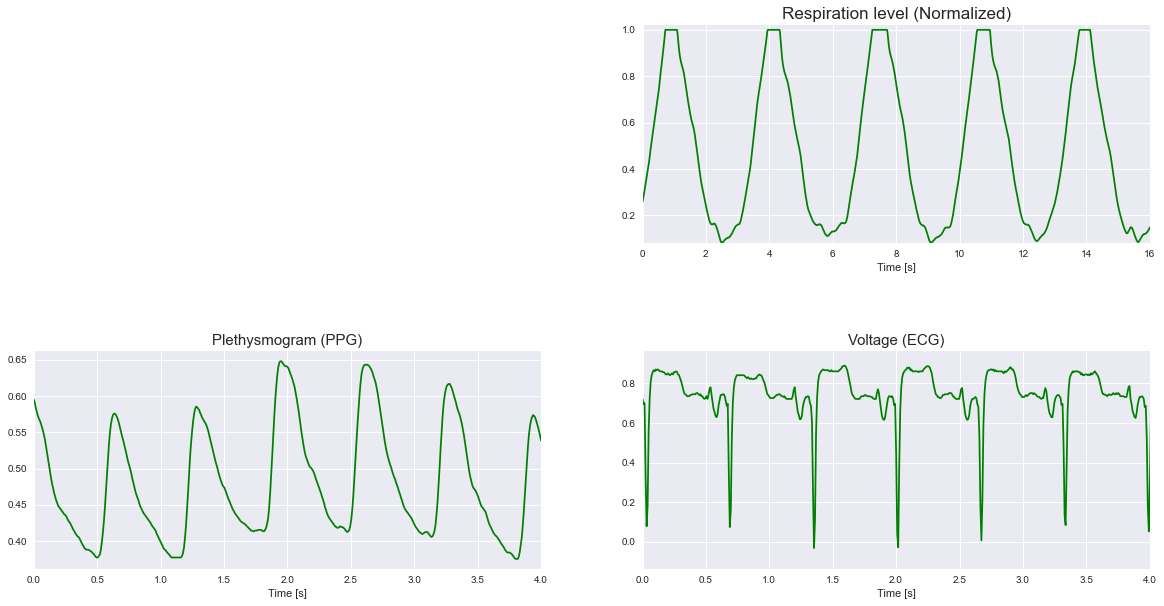

In [15]:
# Import for visualisation library
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.figure(figsize=(20,22))

# Plot for Normalized respiration
plt.subplot(4,2,2)
plt.plot(df['Time [s]'].loc[:2000],df[' RESP'].loc[:2000], color='green')
plt.xlabel('Time [s]')
plt.title('Respiration level (Normalized)',fontsize=17)
plt.ylim(min(df[' RESP'].loc[:2000]),1.02)
plt.xlim(0,16)

# Plot for Plethysmogram signals extracted from all patients
plt.subplot(4,2,3)
plt.plot(df['Time [s]'].loc[:500],df[' PLETH'].loc[:500], color='green')
plt.xlabel('Time [s]')
plt.xlim(0,4)
plt.title('Plethysmogram (PPG)',fontsize=15)

# Plot for Electrocardiogram signals extracted from all patients
plt.subplot(4,2,4)
plt.plot(df['Time [s]'],df[' V'], color='green')
plt.xlabel('Time [s]')
plt.xlim(0,4)
plt.title('Voltage (ECG)',fontsize=15)

sns.set(style='dark',)

# Subplots adjustmensts for display
plt.subplots_adjust(hspace=0.5)
plt.show()

### Comparison of different Machine Learning models

In [16]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Imports for the implementation of different Machine Learning models

In [17]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import Lasso,Ridge, ElasticNet, BayesianRidge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import warnings
from joblib import dump, load
from os import listdir, mkdir
from os.path import isdir, isfile, join
warnings.filterwarnings('ignore')

### Extracting all the patients data

In [18]:
# Extracting data from the collated and preprocessed dataset 
personsData = pd.read_csv('person_csvs/all_people.csv', index_col=0)

In [ ]:

# Seperating all columns containing RESP as it's starting name
respVal = [a for a in personsData.columns if 'RESP' in a and a != ' RESP']
personsData.drop(respVal + ['Time [s]', 'sec'], axis=1, inplace=True)

In [19]:
# Number data points in the dataset
personsData.value_counts().sum()

2700044

In [20]:
# Segment of data from all person csv file
personsData.head()

,RESP,PLETH,V,AVR,II,HR,PULSE,SpO2,PLETH_Min,V_Min,...,AVR_Mean,II_Mean,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,1.0,0.51026,0.96667,1.09380,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
1,1.0,0.50342,1.05690,1.09960,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
2,1.0,0.49462,1.07250,1.04880,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
3,1.0,0.48680,1.00590,1.00390,-0.38477,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
4,1.0,0.47996,0.95098,0.95898,-0.21875,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067


In [21]:
# Person data for 64 sec window
data = personsData.iloc[0:68125,:]
data

,RESP,PLETH,V,AVR,II,HR,PULSE,SpO2,PLETH_Min,V_Min,...,AVR_Mean,II_Mean,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,1.00000,0.51026,0.96667,1.09380,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
1,1.00000,0.50342,1.05690,1.09960,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
2,1.00000,0.49462,1.07250,1.04880,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
3,1.00000,0.48680,1.00590,1.00390,-0.38477,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
4,1.00000,0.47996,0.95098,0.95898,-0.21875,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68120,0.26882,0.53079,0.55479,0.37562,0.52956,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68121,0.26491,0.55914,0.57045,0.35961,0.54557,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68122,0.26197,0.58651,0.58023,0.33990,0.56527,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68123,0.25806,0.60997,0.58513,0.32020,0.58498,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518


In [22]:
# Normalizing the predictive data
SC = StandardScaler()
X = data.drop(' RESP', axis=1)
SC.fit(X, y = None)

In [ ]:
# Splitting dependent and independent variables
y = data[' RESP'].values
X = SC.transform(X)

### Implementation of different ML models 

In the below code segment, 9 different Machine Learnig algorithims are used to identify the best Machine Learning algorithm for the BIDMC dataset for respiratory rate estimation.

The algorithms are:
1. Linear Regression
2. Elastic net
3. Bayesian Ridge
4. K Neighbors Regression
5. Random Forest Regression
6. Ada Boost Regression
7. Extreme Gradient Boost Regression
8. Lasso Regression
9. Ridge Regression

In [25]:
# ML models stored in a dictionary3sk
MLmodels = {
           'LinearRegression':LinearRegression(),
           'BayesianRidge':BayesianRidge(),
           'AdaBoostR': AdaBoostRegressor(),
           'XGBR':XGBRegressor(),
           'LassoR':Lasso(),
           'RidgeR':Ridge(),
           'KNN-R':KNeighborsRegressor(),
           'RF-R':RandomForestRegressor(),
           'ElasticNet':ElasticNet(),
         }

In [26]:
# General function to run all the ML models
def ML_model_performance(X, y):

# Array to hold values of algorithms time and values
    runTime = []
    keysValues = []

# Arrays to hold values of metrics
    mean_abs_error = []
    mean_squared_errors = []
    r2_scores = []
    
# Train test Split for training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)

    for n, i in tqdm(MLmodels.items()):
        
        model = i
        t0 = time.time()

# Fitting model to be trained later
        model.fit(X_train, y_train)

# Extracting train time for each model
        train_time = time.time()-t0
        t1 = time.time()
        
        pred = model.predict(X_test)
        
        predictTime = time.time() - t1
        
        pred = pd.Series(pred)
        TimeTotal = train_time + predictTime
        
        runTime.append(TimeTotal)

# Metrics for judging Supervised Learning Algorithms
        r2_scores.append(r2_score(y_test,pred))
        mean_squared_errors.append(mean_squared_error(y_test,pred))
        mean_abs_error.append(mean_absolute_error(y_test,pred))
        
        keysValues.append(n)

# Metrics stored in one table
    metricsTable = pd.DataFrame({
                            'model':keysValues, 
                            'RMSE':mean_squared_errors, 
                            'MAE':mean_abs_error, 
                            'R2 score':r2_scores, 
                            'time':runTime
                        })
    
    metricsTable['RMSE'] = metricsTable['RMSE'].apply(lambda x: np.sqrt(x))
    
    return metricsTable

In [27]:
# ML Models performance mesurement function
ML_model_performance(X, y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.25s/it]


,model,RMSE,MAE,R2 score,time
0,LinearRegression,0.327985,0.272190,0.372744,0.090463
1,BayesianRidge,0.327991,0.272236,0.372720,0.069433
2,AdaBoostR,0.321011,0.285015,0.399136,2.195367
3,XGBR,0.155937,0.102330,0.858213,2.530214
4,LassoR,0.414127,0.381903,-0.000010,0.025485
5,RidgeR,0.328017,0.272396,0.372622,0.022823
6,KNN-R,0.140933,0.060027,0.884185,13.760796
7,RF-R,0.108051,0.048205,0.931924,28.534862
8,ElasticNet,0.414127,0.381903,-0.000010,0.028881


# (ii) Random Forest Regression 

Since random forest regression provides the best results amongst the 9 Machine learning algorithms, therefore, In the below mentioned code section I am going to implement performance measurement with respect just to the random forest

### Imports for Data visualization

In [29]:
# Imports for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats

### Implementation of Random Forest Model

In [30]:
# Extracting data from the collated and preprocessed dataset 
personsData = pd.read_csv('person_csvs/all_people.csv', index_col=0)

In [ ]:
# Seperating all columns containing RESP as it's starting name
respVal = [a for a in personsData.columns if 'RESP' in a and a != ' RESP']
personsData.drop(respVal + ['Time [s]', 'sec'], axis=1, inplace=True)

In [31]:
# Person data for 64 sec window
data = personsData.iloc[0:68125,:]
data

,RESP,PLETH,V,AVR,II,HR,PULSE,SpO2,PLETH_Min,V_Min,...,AVR_Mean,II_Mean,PLETH_Kurt,V_Kurt,AVR_Kurt,II_Kurt,PLETH_Skw,V_Skw,AVR_Skw,II_Skw
0,1.00000,0.51026,0.96667,1.09380,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
1,1.00000,0.50342,1.05690,1.09960,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
2,1.00000,0.49462,1.07250,1.04880,-0.49805,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
3,1.00000,0.48680,1.00590,1.00390,-0.38477,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
4,1.00000,0.47996,0.95098,0.95898,-0.21875,83.0,76.0,93.0,0.35582,0.38431,...,0.887454,-0.013531,-0.194636,15.944799,33.391568,20.838215,1.021846,-1.844611,-4.965551,2.869067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68120,0.26882,0.53079,0.55479,0.37562,0.52956,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68121,0.26491,0.55914,0.57045,0.35961,0.54557,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68122,0.26197,0.58651,0.58023,0.33990,0.56527,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518
68123,0.25806,0.60997,0.58513,0.32020,0.58498,76.0,76.0,96.0,0.24829,0.22505,...,0.448632,0.450591,-0.911239,17.835666,5.615009,0.724230,0.696902,-3.291395,2.072455,0.822518


In [32]:
# Normalizing the predictive data
SC = StandardScaler()
X = data.drop(' RESP', axis=1)
SC.fit(X, y = None)
columnsVal = X.columns

In [ ]:
# Splitting dependent and independent variables
y = data[' RESP'].values
X = SC.transform(X)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# Random Forest Model initialized
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Prediction implemented based on the label extracted
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

# Metrics to judge the model
MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print('MSE:', MSE)
print('MAE:', MAE)
print('R2:', R2)

MSE: 0.011669432909286232
MAE: 0.04781994843345304
R2: 0.9319564263003949


### Visualization of error in the prediction 

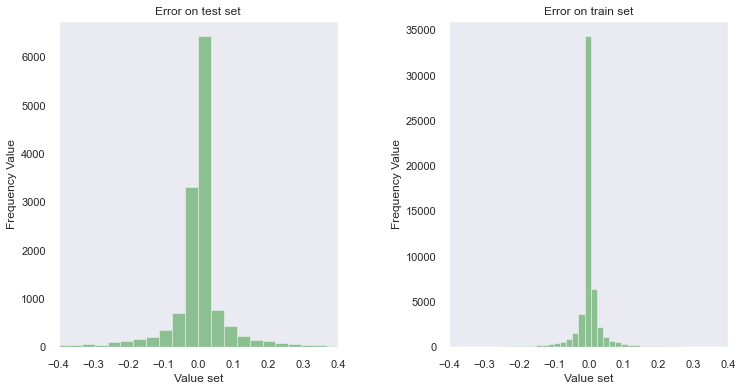

In [34]:
# Extracting and visualizing errors in dataset of test and train
errors_on_test = pd.DataFrame((y_pred - y_test)).dropna()
errors_on_train = pd.DataFrame((y_pred_train - y_train)).dropna()

# Initializing figure size
plt.figure(figsize=(12, 6))

# Subplot for error on test
plt.subplot(1, 2, 1)
plt.title('Error on test set')
plt.xlabel('Value set')
plt.ylabel('Frequency Value')
sns.distplot(errors_on_test, hist=True, kde=False, color='green')
plt.xlim(-0.4, 0.4)

# subplot for error on train
plt.subplot(1, 2, 2)
plt.title('Error on train set')
plt.xlabel('Value set')
plt.ylabel('Frequency Value')
sns.distplot(errors_on_train, hist=True, kde=False, color='green')
plt.xlim(-0.4, 0.4)

# Theme of figues
sns.set(style='dark',)

plt.subplots_adjust(wspace=0.4)
plt.show()

In [41]:
# Extracting the dataset
X = pd.DataFrame(X, columns=columnsVal)

In [42]:
# Feature extraction for feature imporatnce in the algorithm
importantFeatures = model.feature_importances_
std = np.std([model.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importantFeatures)[::-1]

In [44]:
# Printing the ranking of important features
print("Ranking of Features according to their importance:")

# Sorting features on per their importance
feature_importances = []
for a in range(X.shape[1]):
    print("%d. %s (%f)" % (a + 1, X.columns[indices[a]], importantFeatures[indices[a]]))
    feature_importances.append((X.columns[indices[a]], importantFeatures[indices[a]]))

importantVal = [n[1] for n in feature_importances]
importantNames = [n[0] for n in feature_importances]

Ranking of Features according to their importance:
1.  AVR_Mean (0.338486)
2.  PLETH (0.117453)
3.  V_Mean (0.064629)
4.  V (0.047077)
5.  II_Mean (0.045718)
6.  AVR (0.044352)
7.  II (0.035381)
8.  AVR_Max (0.030928)
9.  AVR_Min (0.027517)
10.  II_Max (0.024671)
11.  II_Kurt (0.018784)
12.  PLETH_Min (0.018254)
13.  PLETH_Max (0.017943)
14.  PLETH_Skw (0.015920)
15.  PULSE (0.015420)
16.  II_Skw (0.014870)
17.  V_Skw (0.014574)
18.  AVR_Kurt (0.014511)
19.  V_Max (0.014360)
20.  PLETH_Mean (0.013111)
21.  PLETH_Kurt (0.012502)
22.  V_Min (0.012319)
23.  HR (0.012028)
24.  V_Kurt (0.009287)
25.  II_Min (0.008061)
26.  AVR_Skw (0.007251)
27.  SpO2 (0.004594)


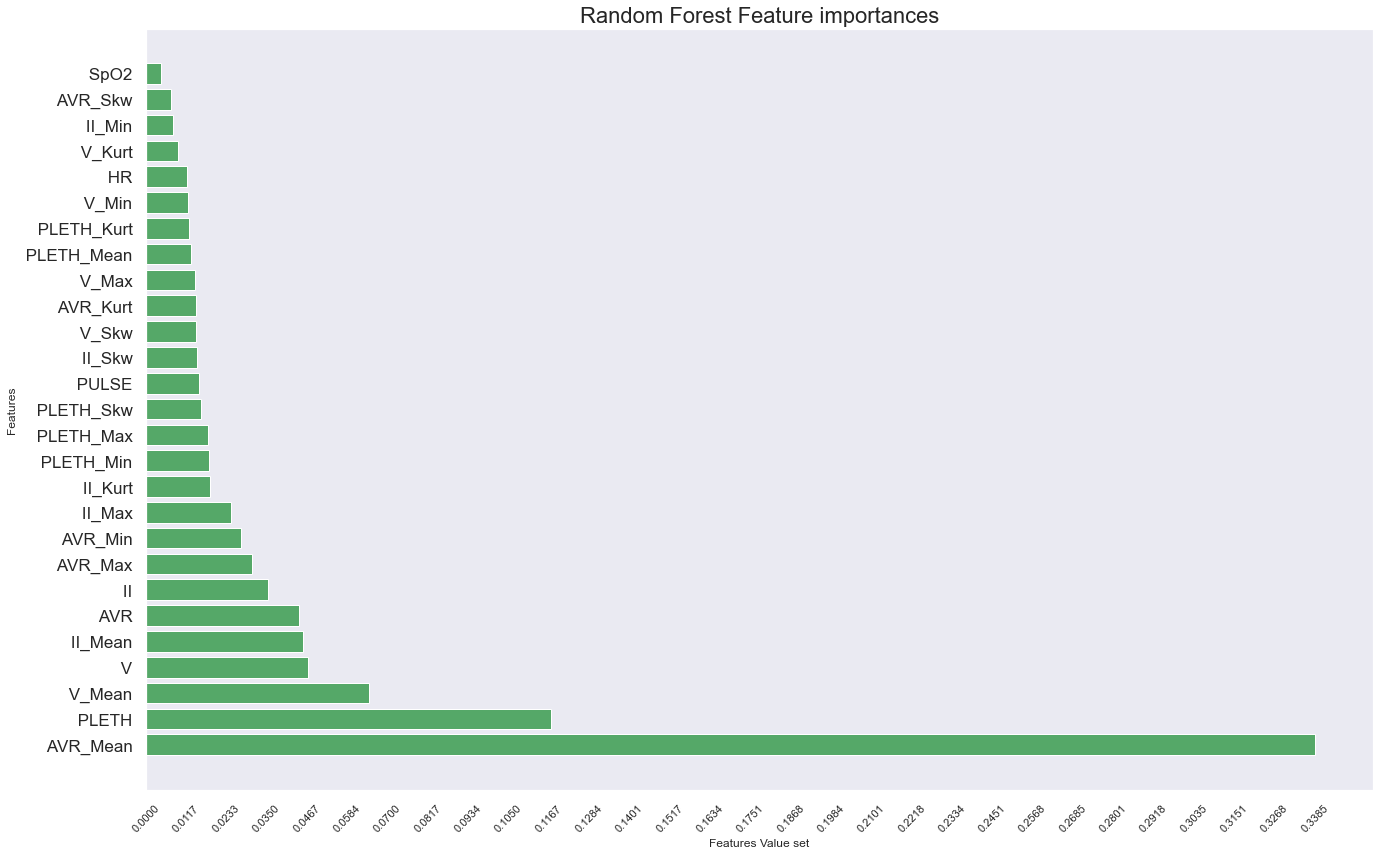

In [47]:
# Important features of random forest are sorted and displayed
plt.figure(figsize=(22,14))
plt.title("Random Forest Feature importances", fontsize=22)
plt.barh(range(len(importantNames)), importantVal, color="g", yerr=std[indices], align="center")
plt.xlabel('Features Value set')
plt.ylabel('Features')

# Displaying features on x and y axis
plt.yticks(range(len(importantNames)), importantNames, fontsize=17)
plt.xticks(np.linspace(0, max(importantFeatures), 30), rotation=46)
plt.show()

# (iii) Deep Learning approach to respiratory rate estimation

### Imports for deep learning implementation

In [8]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Instructions for updating:
non-resource variables are not supported in the long term


In [49]:
# data extraction in the form of columns
column_array = [0]*54
for n in range(0,54):
    column_array[n] = n

In [50]:
# Data extraction from all the files stored of all the patients in BIDMC dataset
filePath1 ='/Users/safi/Documents/data/Day1/Post/DataFeatures1.csv'
filePath2 ='/Users/safi/Documents/data/Day2/Post/DataFeatures2.csv' 

In [ ]:
filePath3 ='/Users/safi/Documents/data/Day2/Post/DataFeatures3.csv' 
filePath4 ='/Users/safi/Documents/data/Day3/Post/DataFeatures4.csv'
filePath5 ='/Users/safi/Documents/data/Day4/Post/DataFeatures5.csv'

In [51]:
# Data frames for data extracted from the database
dataf1=(pd.read_csv(filePath1 ,header = None, usecols = column_array))
dataf2=(pd.read_csv(filePath2 ,header = None, usecols = column_array))

In [ ]:
dataf3=(pd.read_csv(filePath3 ,header = None, usecols = column_array))
dataf4=(pd.read_csv(filePath4 ,header = None, usecols = column_array))
dataf5=(pd.read_csv(filePath5 ,header = None, usecols = column_array))

In [52]:
# data frames to arrays
dataf1 = np.array(dataf1)
dataf2 = np.array(dataf2)

In [ ]:
dataf3 = np.array(dataf3)
dataf4 = np.array(dataf4)
dataf5 = np.array(dataf5)

In [53]:
# collating all the data frames into one single data frame
dataf = np.concatenate((dataf1, dataf2, dataf3, dataf4, dataf5))
dataf = pd.DataFrame(dataf)
dataf = dataf.fillna(0)

In [54]:
# extracting labels and targets

a = [n for n in range(1, 53)]

Y = dataf[53]
X = dataf[a]
X = np.array(X)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [ ]:
X = X[:-520]
Y = Y[:-520]

In [55]:
# Shape of labels and target
print(X.shape)
print(Y.shape)

(115098, 52)
(115098, 1)


In [56]:
# Cross validation of the data and train test splitting
crossval_split = 0.4
length_train = int( X.shape[0] * (1 - crossval_split) )
length_CrossVal = int( X.shape[0] * crossval_split )

In [57]:
# Labels and features stored in their respective values
X_train = X[0 : length_train]
Y_train = Y[0 : length_train]

In [ ]:
X_CrossVal = X[length_train : ]
Y_CrossVal = Y[length_train : ]

In [58]:
# Printing shapes of train test split
print(X_train.shape)
print(Y_train.shape)
print(X_CrossVal.shape)
print(Y_CrossVal.shape)

(69058, 52)
(69058, 1)
(46040, 52)
(46040, 1)


Text(0.5, 1.0, 'Enhanced Respiratory Rate')

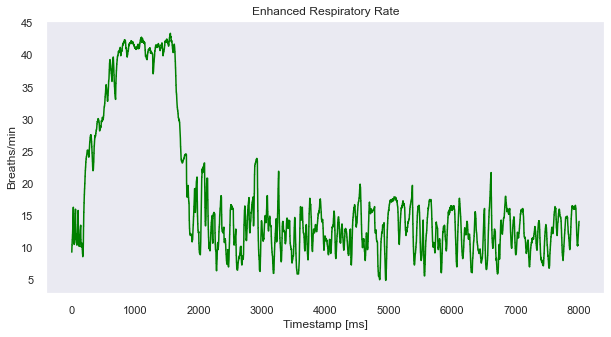

In [59]:
# raw respiratory rate within a segmented timestamp
plt.figure(figsize=(10,5))
plt.plot(Y_train[0:8000], color='green')
plt.xlabel('Timestamp [ms]')
plt.ylabel('Breaths/min')
plt.title('Enhanced Respiratory Rate')

Text(0.5, 1.0, 'Entire dataset Respiratory Rate')

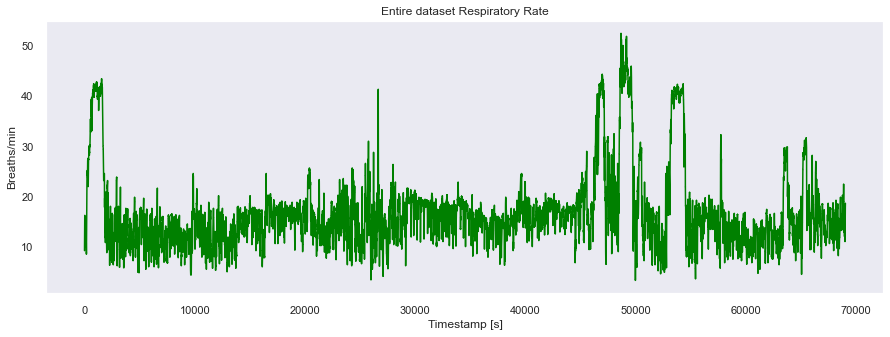

In [60]:
# raw segmentation of respiratory rate of the entire dataset
plt.figure(figsize=(15,5))
plt.plot(Y_train, color='green')
plt.xlabel('Timestamp [s]')
plt.ylabel('Breaths/min')
plt.title('Entire dataset Respiratory Rate')

In [61]:
# implementation of absolute gradient for first order derivative
gradient = np.gradient(Y_train[:,0])
absolute_gradient = np.absolute(gradient)

Text(0, 0.5, 'Respiratory Rate [breaths/min]')

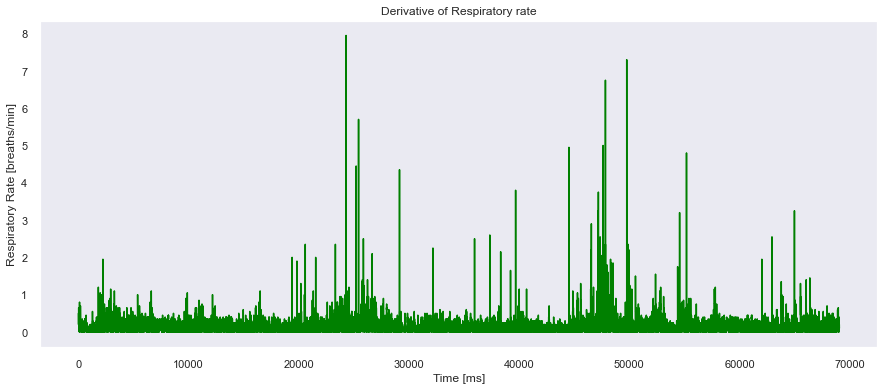

In [62]:
# Visualization of first order derivation of 
plt.figure(figsize=(15,6))
plt.plot(absolute_gradient, color='green')
plt.title('Derivative of Respiratory rate')
plt.xlabel('Time [ms]')
plt.ylabel('Respiratory Rate [breaths/min]')

In [63]:
# Setting threshold for breaths per minute
thresh = 5 

# Implementation of breaths per minute within threshold limit
for n in range(absolute_gradient.shape[0]):
    if(absolute_gradient[n] < thresh):
        absolute_gradient[n] = 0

Text(0, 0.5, 'Respiratory Rate [breaths/min]')

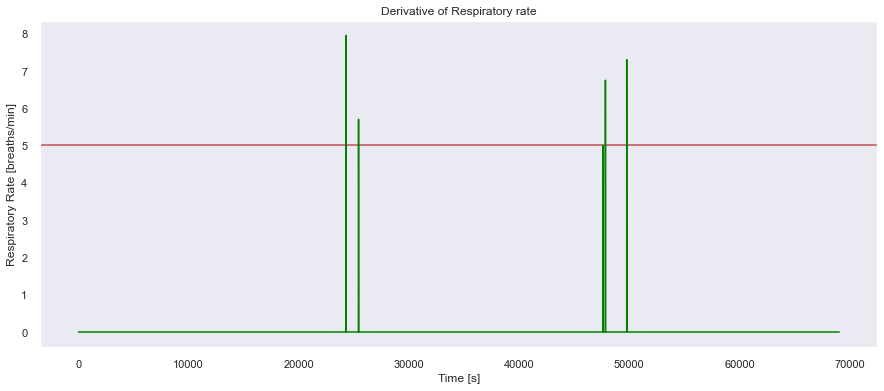

In [64]:
plt.figure(figsize=(15,6))
plt.axhline(y=thresh, color='r', linestyle='-')
plt.plot(absolute_gradient, color='green')
plt.title('Derivative of Respiratory rate')
plt.xlabel('Time [s]')
plt.ylabel('Respiratory Rate [breaths/min]')

In [65]:
# Extracting non zeros from first order derivate 
np.nonzero(absolute_gradient)

(array([24292, 24293, 25423, 25424, 47617, 47829, 47830, 49762, 49763]),)

In [66]:
# Train Split of selected data set
X_train1 = X_train[  0   : 24270]
Y_train1 = Y_train[  0   : 24270]

In [ ]:
X_train2 = X_train[25500 : 47600]
Y_train2 = Y_train[25500 : 47600]

In [ ]:
X_train3 = X_train[50000 : 91300]
Y_train3 = Y_train[50000 : 91300]

Text(0.5, 0, 'Timestamp [s]')

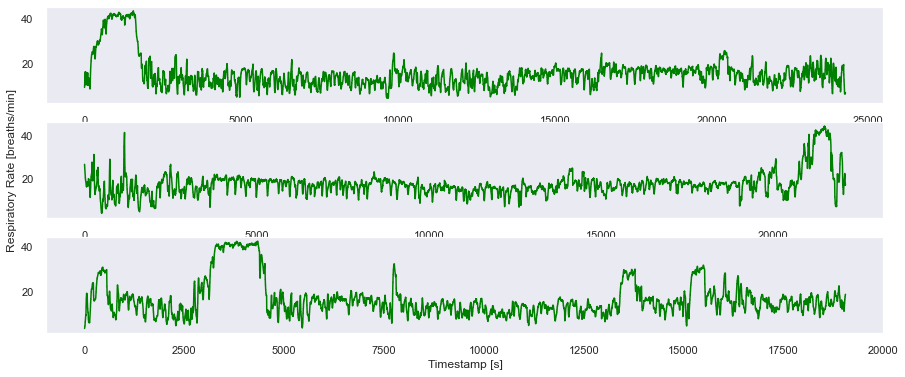

In [67]:
# Visualization of train test split
plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.plot(Y_train1, color='green')

plt.subplot(3,1,2)
plt.plot(Y_train2, color='green')
plt.ylabel('Respiratory Rate [breaths/min]')

plt.subplot(3,1,3)
plt.plot(Y_train3, color='green')
plt.xlabel('Timestamp [s]')

In [68]:
# Mean respiratory rate from all 3 train segemnts of the database
meanRespRate = (np.sum(Y_train1) + np.sum(Y_train2) + np.sum(Y_train3))/(Y_train1.shape[0]+Y_train2.shape[0]+Y_train3.shape[0])
print(meanRespRate)

16.25506358134132


In [69]:
# Implementation of pca on entire data set
%matplotlib inline
pcaValCheck = PCA()

PCA()

In [ ]:
pcaValCheck.fit(X_train1)

In [ ]:
pcaValCheck.fit(X_train2)

In [ ]:
pcaValCheck.fit(X_train3)

In [70]:
# Variance ratio of PCA
print(pcaValCheck.explained_variance_ratio_)

[9.83923367e-01 7.49713595e-03 3.81356880e-03 2.76493127e-03
 1.75224315e-03 2.31987350e-04 1.14063100e-05 3.29574797e-06
 2.05718963e-06 5.15180932e-09 1.63478927e-09 1.98981121e-10
 4.79699731e-13 3.36553299e-13 2.86599065e-13 2.46757446e-13
 1.68966117e-13 1.65731443e-13 1.43007907e-13 1.27240806e-13
 9.65842334e-14 8.72966803e-14 7.98446462e-14 7.89778437e-14
 6.39815028e-14 6.01076450e-14 5.27390121e-14 3.71128949e-14
 1.34502912e-14 1.10087628e-14 7.38955204e-15 6.59041942e-15
 5.74478200e-15 3.60643575e-15 2.97043179e-15 2.40827443e-15
 2.16971787e-15 1.86756286e-15 1.53149904e-15 1.22716102e-15
 9.84312811e-16 5.22026766e-16 2.52176349e-16 1.69985428e-16
 5.87951860e-17 6.10630937e-18 5.10128044e-18 4.39443433e-18
 1.97606993e-18 1.64953429e-18 1.46199968e-18 1.13981133e-18]


<StemContainer object of 3 artists>

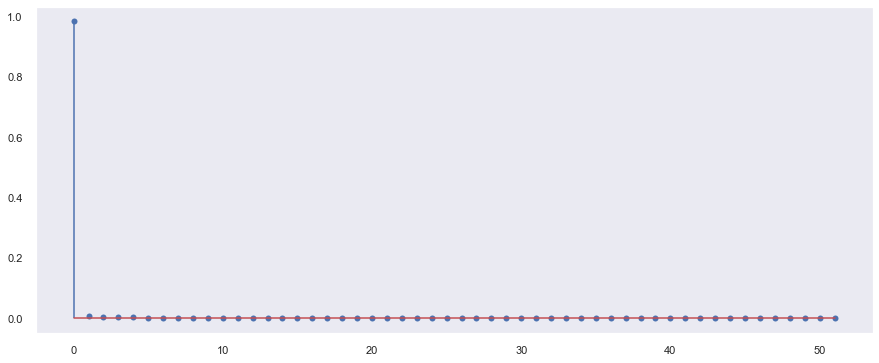

In [77]:
# Dimensionality reduction for PCA visualization
plt.figure(figsize=(15,6))
plt.stem(pcaValCheck.explained_variance_ratio_)

In [78]:
# Sum of variance ratio of PCA values
print(pcaValCheck.explained_variance_ratio_.cumsum())

[0.98392337 0.9914205  0.99523407 0.997999   0.99975125 0.99998323
 0.99999464 0.99999794 0.99999999 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [79]:
# Implementation of PCA
pca_n_components = 9
pcaAnalysis = PCA(n_components=pca_n_components)

pcaAnalysis.fit(X_train1)
pcaAnalysis.fit(X_train2)
pcaAnalysis.fit(X_train3)

X1_pcaAnalysis = pcaAnalysis.transform(X_train1)
X2_pcaAnalysis = pcaAnalysis.transform(X_train2)
X3_pcaAnalysis = pcaAnalysis.transform(X_train3)

print(X1_pcaAnalysis.shape)
print(X2_pcaAnalysis.shape)
print(X3_pcaAnalysis.shape)

(24270, 9)
(22100, 9)
(19058, 9)


In [80]:
# Implementing standard scaler to standardize all the features with Zero mean and unit Variance
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

In [ ]:
scaler_X.fit(X1_pcaAnalysis)
scaler_X.fit(X2_pcaAnalysis)
scaler_X.fit(X3_pcaAnalysis)

In [ ]:
scaler_Y.fit(Y_train1)
scaler_Y.fit(Y_train2)
scaler_Y.fit(Y_train3)

In [ ]:
X_train1 = scaler_X.transform(X1_pcaAnalysis)
X_train2 = scaler_X.transform(X2_pcaAnalysis)
X_train3 = scaler_X.transform(X3_pcaAnalysis)

In [ ]:
Y_train1 = scaler_Y.transform(Y_train1)
Y_train2 = scaler_Y.transform(Y_train2)
Y_train3 = scaler_Y.transform(Y_train3)

In [81]:
# Implementation of tranformations in train/cross-validation data as well
X_CrossVal = pcaAnalysis.transform(X_CrossVal)
X_CrossVal = scaler_X.transform(X_CrossVal)

In [ ]:
Y_CrossVal = scaler_Y.transform(Y_CrossVal)

In [82]:
# Initializing Sequence generation algorithm
def getSequenceData(X, Y, sequencelength):
    a, b = [], []
    for n in range(X.shape[0]-sequencelength):
        a.append(X[n : n+sequencelength])
        b.append(Y[n+sequencelength])
    a = np.array(a)
    b = np.array(b)
    return a, b

In [83]:
# Train test split for 1st train
sequenceLength = 64

X_T1, Y_T1 = getSequenceData(X_train1, Y_train1, sequenceLength)
X_T1, _, Y_T1, _ = train_test_split(X_T1, Y_T1, test_size=1, random_state=2)
print(X_T1.shape)
print(Y_T1.shape)

(24205, 64, 9)
(24205, 1)


In [84]:
# Train test split for 2nd train
X_T2, Y_T2 = getSequenceData(X_train2, Y_train2, sequenceLength)
X_T2, _, Y_T2, _ = train_test_split(X_T2, Y_T2, test_size=1, random_state=2)
print(X_T2.shape)
print(Y_T2.shape)

(22035, 64, 9)
(22035, 1)


In [85]:
# Train test split for 3rd train
X_T3, Y_T3 = getSequenceData(X_train3, Y_train3, sequenceLength)
X_T3, _, Y_T3, _ = train_test_split(X_T3, Y_T3, test_size=1, random_state=2)
print(X_T3.shape)
print(Y_T3.shape)

(18993, 64, 9)
(18993, 1)


In [86]:
# Cross validation of the splits
X_CrossVal, Y_CrossVal = getSequenceData(X_CrossVal, Y_CrossVal, sequenceLength)
print(X_CrossVal.shape)
print(Y_CrossVal.shape)

(45976, 64, 9)
(45976, 1)


In [87]:
# Adjusting shapes of train sets
length_train1 = X_train1.shape[0]

In [ ]:
length_train2 = X_train2.shape[0]

In [ ]:
length_train3 = X_train3.shape[0]

In [ ]:
length_CV = X_CrossVal.shape[0]

In [98]:
# Attributes of the LSTM algorithm
learningRate = 1e-4
batchSize = 128
epochs = 10
inputDimension = pca_n_components

In [ ]:
number_of_hidden1 = 128
number_of_hidden2 = 128

In [ ]:
dropping_probability = 0.3

In [89]:
# Arrays for tarin and CV loss
trainLossArray = []

In [ ]:
cvLossArray = []

In [90]:
# Train batches and splits
total_train_batches1 = int(length_train1/batchSize)

In [ ]:
total_train_batches2 = int(length_train2/batchSize)

In [ ]:
total_train_batches3 = int(length_train3/batchSize)

In [ ]:
total_train_batches_CV = int(length_CV/batchSize)

In [91]:
# Implementing dependent and independent variables
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, sequenceLength, inputDimension])
y = tf.placeholder(tf.float32, [None, 1])

In [92]:
# Implementing weights and Biases
weights = {'lstm2fc1': tf.Variable(tf.random_normal([number_of_hidden2, 64])), 
           'fc1_fc2': tf.Variable(tf.random_normal([64, 1]))}

In [ ]:
biases = {'lstm2fc1': tf.Variable(tf.random_normal([64])), 
          'fc1_fc2': tf.Variable(tf.random_normal([1]))}

In [93]:
# Defining RNN cell to be implemented as LSTM layers
def RNNCell(x, sequenceLength, number_of_hidden):
    x_unstacked_values = tf.unstack(x, sequenceLength, 1)
    lstm_cell_values = tf.nn.rnn_cell.BasicLSTMCell(number_of_hidden)
    outputs_values, states = tf.nn.static_rnn(lstm_cell_values, x_unstacked_values, dtype=tf.float32)
    return outputs_values

In [94]:
# Reference : https://www.oreilly.com/ideas/introduction-to-lstms-with-tensorflow
# Implementing 2 layered RNN cell also called multilevel RNN cell
def MultiRNNCell(x, sequenceLength, batchSize, number_of_hidden1, number_of_hidden2):
    
    x_unstacked_values = tf.unstack(x, sequenceLength, 1)
    
    lstm_cell1_gen = tf.nn.rnn_cell.BasicLSTMCell(number_of_hidden1, state_is_tuple=True)
    lstm_cell2_gen = tf.nn.rnn_cell.BasicLSTMCell(number_of_hidden2, state_is_tuple=True)
    
    cell_values = tf.nn.rnn_cell.MultiRNNCell([lstm_cell1_gen, lstm_cell2_gen], state_is_tuple=True)
    
    init_state_cell = cell_values.zero_state(batchSize, tf.float32)
    
    lstm_outputs_values, final_state = tf.nn.static_rnn(cell_values, x_unstacked_values, initial_state=init_state_cell)
    
    return lstm_outputs_values

In [95]:
outputs_values = MultiRNNCell(x, sequenceLength, batchSize, number_of_hidden1, number_of_hidden2)

dropValues1 = tf.layers.dropout(outputs_values[-1], rate=dropping_probability)
layerValues1 = tf.matmul(dropValues1, weights['lstm2fc1']) + biases['lstm2fc1']
actualvalues1 = tf.nn.relu(layerValues1)

pred = tf.matmul(actualvalues1, weights['fc1_fc2']) + biases['fc1_fc2']

Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [96]:
# Implementing cost function and optimizer for the cost function
cost_function =  tf.losses.mean_squared_error(pred, y)
optimizer_function = tf.train.GradientDescentOptimizer(learning_rate=learningRate).minimize(cost_function)

In [97]:
# Initilizing and saving the cost function and its optimizer
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
# Deep learning algorithm for LSTM implementation to calculate loss and accuracy
with tf.Session() as sess:
    
    if(os.path.isfile('/Users/safi/Documents/model/model.meta')):
        saverRestore = tf.train.import_meta_graph('/Users/safi/Documents/model/model.meta')
        saverRestore.restore(sess, '/Users/safi/Documents/model/model')
        print('Restored Model Successfully')
        
    sess.run(init)
    
    for epoch in range(epochs):
        
        trainLoss = 0
        for batch in range(total_train_batches1):
            batch_x = X_T1[batch*batchSize : (batch+1)*batchSize]
            batch_y = Y_T1[batch*batchSize : (batch+1)*batchSize]
            sess.run(optimizer_function, feed_dict={x : batch_x, y : batch_y})
            trainLoss += sess.run(cost_function, feed_dict={x : batch_x, y : batch_y})
        
        for batch in range(total_train_batches2):
            batch_x = X_T2[batch*batchSize : (batch+1)*batchSize]
            batch_y = Y_T2[batch*batchSize : (batch+1)*batchSize]
            sess.run(optimizer_function, feed_dict={x : batch_x, y : batch_y})
            trainLoss += sess.run(cost_function, feed_dict={x : batch_x, y : batch_y})
        
        for batch in range(total_train_batches3):
            batch_x = X_T3[batch*batchSize : (batch+1)*batchSize]
            batch_y = Y_T3[batch*batchSize : (batch+1)*batchSize]
            sess.run(optimizer_function, feed_dict={x : batch_x, y : batch_y})
            trainLoss += sess.run(cost_function, feed_dict={x : batch_x, y : batch_y})
        
        trainLossArray.append(trainLoss)
        
        
        
        crossval_loss = 0
        for batch in range(total_train_batches_CV):
            batch_x = X_CrossVal[batch*batchSize : (batch+1)*batchSize]
            batch_y = Y_CrossVal[batch*batchSize : (batch+1)*batchSize]
            crossval_loss += sess.run(cost_function, feed_dict={x : batch_x, y : batch_y})
        
        cvLossArray.append(crossval_loss)
        
        save_path = saver.save(sess, "/Users/safi/Documents/model/model")
        
        print('Epoch :', epoch+1, '   Train Loss :', trainLoss, '   CV Loss :', crossval_loss )

INFO:tensorflow:Restoring parameters from /Users/safi/Documents/model/model
Restored Model Successfully
Epoch : 1    Train Loss : 262.5622983723879    CV Loss : 157.8540990864858
Epoch : 2    Train Loss : 138.07631596922874    CV Loss : 143.22549072746187
Epoch : 3    Train Loss : 120.24029292166233    CV Loss : 137.96845615282655
Epoch : 4    Train Loss : 111.70780642330647    CV Loss : 135.19327721651644
Epoch : 5    Train Loss : 106.5475949048996    CV Loss : 134.80210052244365
Epoch : 6    Train Loss : 102.91965436935425    CV Loss : 132.9222911046818
Epoch : 7    Train Loss : 100.26876017451286    CV Loss : 131.7313795434311
Epoch : 8    Train Loss : 98.1269831135869    CV Loss : 130.77734279539436
Epoch : 9    Train Loss : 96.37825983017683    CV Loss : 130.20713412947953
Epoch : 10    Train Loss : 94.92028780281544    CV Loss : 129.6437352579087


/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/528366463.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color='green', marker = '*')
/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/528366463.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, validation_loss, 'r', label='Validation loss', color='red', marker = '*')


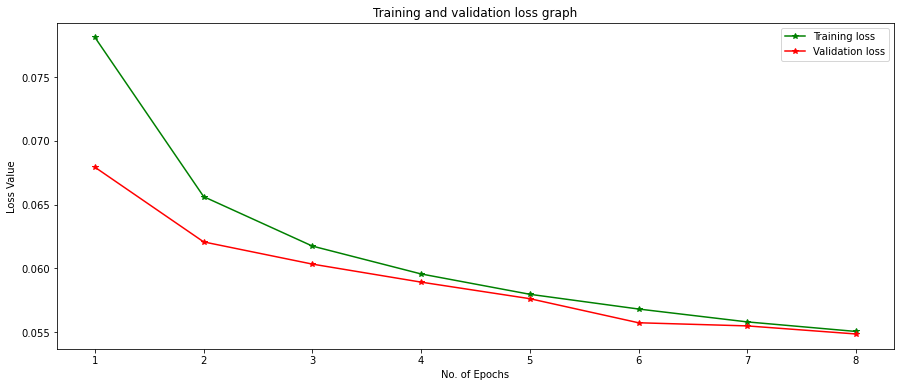

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)

# visualization of the train and validation loss
plt.figure(figsize=(15,6))
plt.plot(epochs, loss, 'y', label='Training loss', color='green', marker = '*')
plt.plot(epochs, validation_loss, 'r', label='Validation loss', color='red', marker = '*')
plt.title('Training and validation loss graph')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss Value')

plt.legend()
plt.show()

In [101]:
# Prediction stored in a model file
Y_pred = []

with tf.Session() as sess:
    saverRestore = tf.train.import_meta_graph('/Users/safi/Documents/model/model.meta')
    saverRestore.restore(sess, '/Users/safi/Documents/model/model')
    
    for batch in range(total_train_batches_CV):
            batch_x = X_CrossVal[batch*batchSize : (batch+1)*batchSize]
            batch_y = Y_CrossVal[batch*batchSize : (batch+1)*batchSize]
            out = sess.run(pred, feed_dict={x : batch_x, y : batch_y})
            Y_pred.append(out)

INFO:tensorflow:Restoring parameters from /Users/safi/Documents/model/model


In [102]:
# Preparing data for implementation of metrics
npArray = np.array(Y_pred)
predictionValue = npArray.ravel()

In [ ]:
prediction_length = predictionValue.shape[0]
original_length = Y_CrossVal.shape[0]

In [103]:
# Measurement metrics implementation
originalVal = scaler_Y.inverse_transform(Y_CrossVal)
predictionVal = scaler_Y.inverse_transform(predictionValue.reshape(-1, 1))

pad = [meanRespRate] * (original_length - prediction_length)
pad = np.array(pad)
predictionVal = np.append(pad, predictionVal)

error = mean_absolute_error(originalVal, predictionVal)
print('MAE =', error)

MAE = 3.859519236136311


Text(0.5, 1.0, 'True Respiratory rate')

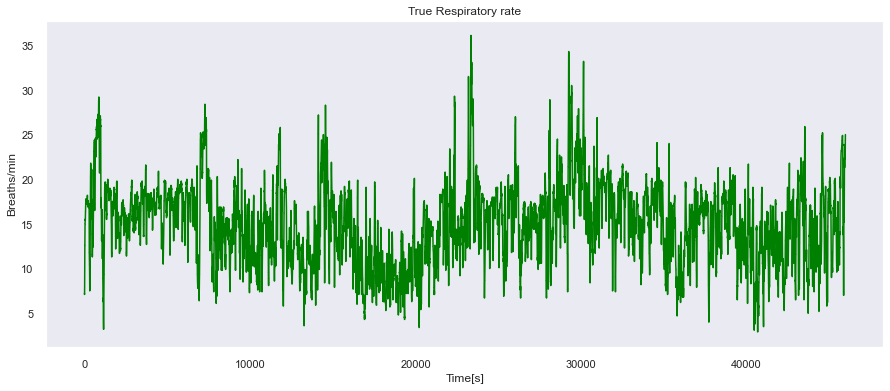

In [105]:
# Visualization of output of deep learning approach
plt.figure(figsize=(15,6))
trueReading, = plt.plot(originalVal, label='True', color= 'green')
#predictedReading, = plt.plot(predictionVal, label='Predicted', color= 'red')
#plt.legend([trueReading, predictedReading], ['True', 'Predicted'])
plt.xlabel('Time[s]')
plt.ylabel('Breaths/min')
plt.title('True Respiratory rate')

Text(0.5, 1.0, 'Predicted Respiratory Rate')

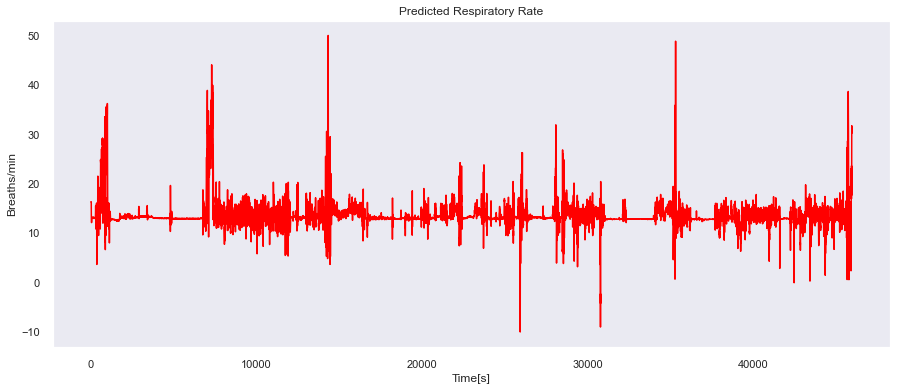

In [106]:
# Visualization of output of deep learning approach
plt.figure(figsize=(15,6))
#trueReading, = plt.plot(originalVal, label='True', color= 'green')
predictedReading, = plt.plot(predictionVal, label='Predicted', color= 'red')
#plt.legend([trueReading, predictedReading], ['True', 'Predicted'])
plt.xlabel('Time[s]')
plt.ylabel('Breaths/min')
plt.title('Predicted Respiratory Rate')

Text(0.5, 1.0, 'Respiratory Rate')

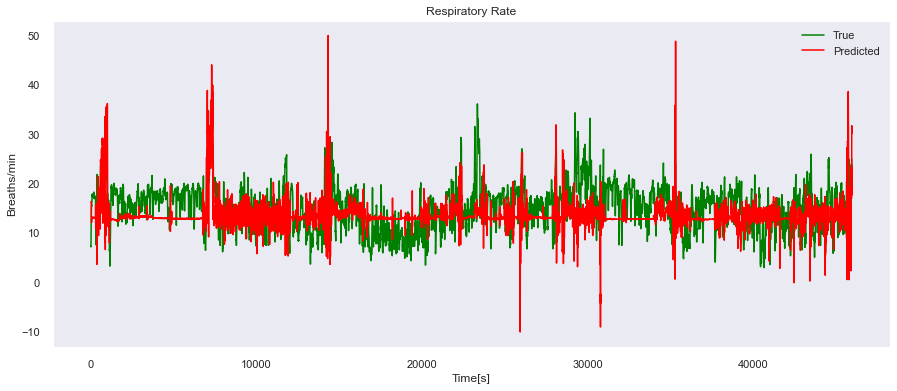

In [107]:
# Visualization of output of deep learning approach
plt.figure(figsize=(15,6))
trueReading, = plt.plot(originalVal, label='True', color= 'green')
predictedReading, = plt.plot(predictionVal, label='Predicted', color= 'red')
plt.legend([trueReading, predictedReading], ['True', 'Predicted'])
plt.xlabel('Time[s]')
plt.ylabel('Breaths/min')
plt.title('Respiratory Rate')

# (iv) Implementation of Neural Network

In [1]:
import keras
import sklearn
import pandas as pd

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Extracting data from the collated and preprocessed dataset 
personsDataNN = pd.read_csv('person_csvs/all_people.csv', index_col=0)

# Seperating all columns containing RESP as it's starting name
respVal = [a for a in personsDataNN.columns if 'RESP' in a and a != ' RESP']
personsDataNN.drop(respVal + ['Time [s]', 'sec'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
# Normalizing the predictive data
SC = StandardScaler()
X = personsDataNN.drop(' RESP', axis=1)
SC.fit(X, y = None)

In [ ]:
# Splitting dependent and independent variables
y = personsDataNN[' RESP'].values
X = SC.transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [29]:
# Implementation of neural network
model = Sequential()

#Input layers
model.add(Dense(128, input_dim=27, activation='relu'))
model.add(Dense(64, activation='relu'))

#Implementation of output layer
model.add(Dense(1, activation='linear'))

# Compiling summary of the model implemented
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mae'])
model.summary()

model_fit = model.fit(X_train, y_train, validation_split=0.19, epochs =8)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 128)               3584      
                                                                 
 dense_34 (Dense)            (None, 64)                8256      
                                                                 
 dense_35 (Dense)            (None, 1)                 65        
                                                                 
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________
Train on 1749628 samples, validate on 410407 samples
Epoch 1/8
1749628/1749628 [==============================] - 47s 27us/sample - loss: 0.0747 - mean_absolute_error: 0.2099 - val_loss: 0.0646 - val_mean_absolute_error: 0.1927
Epoch 2/8
1749628/1749628 [==============================] - 47s 27us/sample - loss: 

/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/528366463.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'y', label='Training loss', color='green', marker = '*')
/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/528366463.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, validation_loss, 'r', label='Validation loss', color='red', marker = '*')


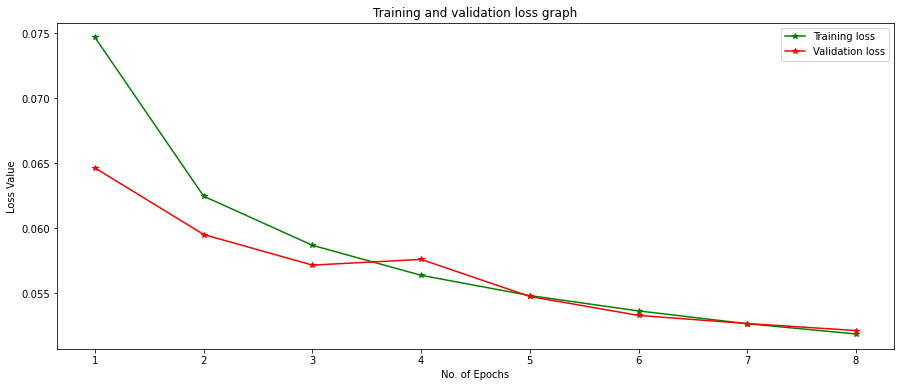

In [30]:
#plot the training and validation accuracy and loss at each epoch
loss = model_fit.history['loss']
validation_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)

# visualization of the train and validation loss
plt.figure(figsize=(15,6))
plt.plot(epochs, loss, 'y', label='Training loss', color='green', marker = '*')
plt.plot(epochs, validation_loss, 'r', label='Validation loss', color='red', marker = '*')
plt.title('Training and validation loss graph')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss Value')

plt.legend()
plt.show()

/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/2628148417.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y" (-> color=(0.75, 0.75, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc, 'y', label='Training MAE', color='green', marker = '*')
/var/folders/c0/sj969k_x7xs_y65cm0gnh58c0000gn/T/ipykernel_12366/2628148417.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc, 'r', label='Validation MAE', color='red', marker = '*')


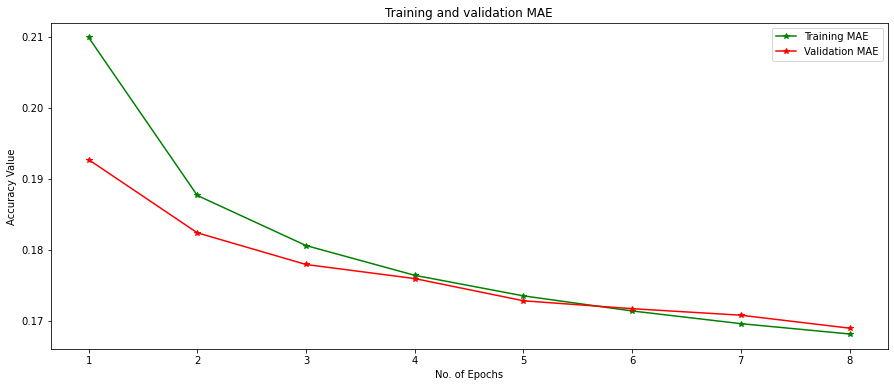

In [31]:
#plot the training and validation accuracy and MAE at each epoch
acc = model_fit.history['mean_absolute_error']
val_acc = model_fit.history['val_mean_absolute_error']

# Visualization of training and validation MAE
plt.figure(figsize=(15,6))
plt.plot(epochs, acc, 'y', label='Training MAE', color='green', marker = '*')
plt.plot(epochs, val_acc, 'r', label='Validation MAE', color='red', marker = '*')
plt.title('Training and validation MAE')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy Value')
plt.legend()
plt.show()

In [32]:
# Implementation of predictions after model has been trained
predictions = model.predict(X_test[:5])
print("Predicted values are: ", predictions)
print("Real values are: ", y_test[:5])

/opt/anaconda3/lib/python3.9/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Predicted values are:  [[0.39041013]
 [0.6537681 ]
 [0.7614794 ]
 [0.72669774]
 [0.4108946 ]]
Real values are:  [-4.8864e-04  4.9709e-01  4.1153e-01  1.0000e+00  5.1112e-01]


In [33]:
# Comparitive metrics implementation
mse_neural_network, mae_neural_network = model.evaluate(X_test, y_test)
print('Mean squared error from neural net: ', mse_neural_network)
print('Mean absolute error from neural net: ', mae_neural_network)

Mean squared error from neural net:  0.05203403267456255
Mean absolute error from neural net:  0.16896859
